###  Part 2: https://www.youtube.com/watch?v=TCH_1BHY58I
 Paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from typing import List, Tuple

In [2]:
# read the data

words = open("names.txt", "r").read().splitlines()
len(words)

32033

In [3]:
chars = sorted(list(set(''.join(words)))) 
s2i = {s: i + 1 for i, s in enumerate(chars)}
s2i["."] = 0
i2s = {i: s for s, i in s2i.items()}

In [4]:
# build the dataset

block_size = 3

X, Y = [], [] # input, labels

for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = s2i[ch]
        X.append(context)
        Y.append(ix)
        print(f"{''.join([i2s[i] for i in context])} ---> {i2s[ix]}")
        context = context[1:] + [ix]
    
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [5]:
EMB_SIZE = 2
C = torch.randn((27, EMB_SIZE))

In [6]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [7]:
W1 = torch.randn((EMB_SIZE * block_size, 100))
b1 = torch.randn((100,))

torch.cat() @ W1 + b1

TypeError: cat() received an invalid combination of arguments - got (), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


In [8]:
h = torch.tanh(emb.view(emb.shape[0], block_size * EMB_SIZE) @ W1 + b1)

In [9]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27,))

logits = h @ W2 + b2

counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)


In [10]:
loss = probs[torch.arange(32), Y].log().mean()
loss

tensor(-12.9928)

In [36]:
n_hidden = 300
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, EMB_SIZE), generator=g)
W1 = torch.randn((EMB_SIZE * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden,), generator=g)
W2 = torch.randn((n_hidden, 27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2]

n_params = (sum(p.nelement() for p in parameters))
print(f"Number of parameters: {n_params}")	

Number of parameters: 10281


In [43]:
learning_rate = 0.01

lri = []
lossi = []
stepi = []

for p in parameters:
    p.requires_grad = True

for i in range(30000):

    ix = torch.randint(0, X.shape[0], (128,))

    # forward
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(emb.shape[0], block_size * EMB_SIZE) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # probs = counts / counts.sum(dim=1, keepdim=True)
    # loss = -probs[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    for p in parameters:
        p.grad = None
    loss.backward()
    # lr = lrs[i]
    # lri.append(lr_exp[i])
    # lossi.append(loss.item())

    stepi.append(i)
    lossi.append(loss.item())
    for p in parameters:
        p.data += -learning_rate * p.grad

print(f"Loss: {loss.item():.2f}")

Loss: 2.36


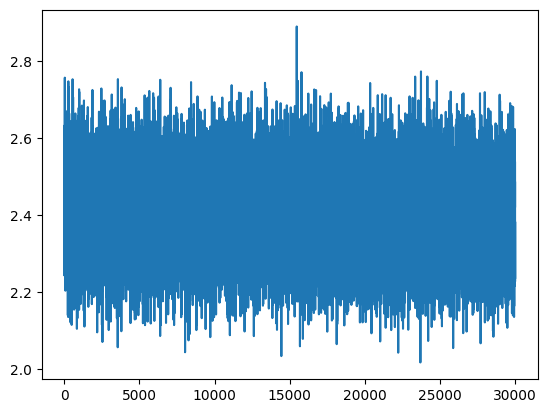

In [42]:
plt.plot(stepi, lossi)

In [44]:
# train, dev, test
# 80%, 10%, 10%

def build_dataset(words: List[str]):
    X, Y = [], [] # input, labels
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = s2i[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [25]:
X_train.shape, X_dev.shape, X_test.shape

(torch.Size([182580, 3]), torch.Size([22767, 3]), torch.Size([22799, 3]))

In [75]:
n_hidden = 200
EMB_SIZE = 10
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, EMB_SIZE), generator=g)
W1 = torch.randn((EMB_SIZE * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden,), generator=g)
W2 = torch.randn((n_hidden, 27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2]

n_params = (sum(p.nelement() for p in parameters))
print(f"Number of parameters: {n_params}")	

Number of parameters: 11897


In [76]:

lri = []
lossi = []
stepi = []

In [77]:
learning_rate = 0.01


for p in parameters:
    p.requires_grad = True

for i in range(200000):

    learning_rate = 0.1 if i < 100000 else 0.01
    ix = torch.randint(0, X_train.shape[0], (32,))

    # forward
    emb = C[X_train[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(emb.shape[0], block_size * EMB_SIZE) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # probs = counts / counts.sum(dim=1, keepdim=True)
    # loss = -probs[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y_train[ix])
    # print(loss.item())
    for p in parameters:
        p.grad = None
    loss.backward()
    # lr = lrs[i]
    # lri.append(lr_exp[i])
    # lossi.append(loss.item())

    stepi.append(i)
    lossi.append(loss.log10().item())

    for p in parameters:
        p.data += -learning_rate * p.grad

print(f"Loss: {loss.item():.2f}")

Loss: 2.02


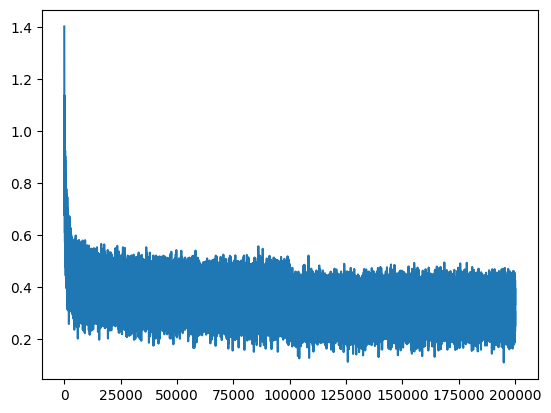

In [79]:
plt.plot(stepi, lossi)

In [78]:
emb = C[X_dev]
h = torch.tanh(emb.view(emb.shape[0], block_size * EMB_SIZE) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_dev)
print(f"Loss: {loss.item():.2f}")


Loss: 2.20


In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(C[:,0].data, C[:, 1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i, 1].item(), i2s[i], ha="center", va="center",color="white")

plt.grid("minor")

In [80]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, block_size * EMB_SIZE) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([i2s[i] for i in out[:-1]]))

mona
kayah
seer
nihahlie
emmaniendrari
azery
meli
jemperen
edellestanar
katelle
kalin
sher
rishiriel
kendreelle
joseus
kuna
ged
ryyah
faekshiah
myston
